In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = 'VvmHMhvuE13zMSZxgCEC'

import cvxportfolio as cp

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

In [4]:
tickers = ['SPY', 'TLT', 'VNQ', 'FXY', 'VWO', 'GDX']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('EOD/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj_Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,SPY,TLT,VNQ,FXY,USDOLLAR
Date,,,,,
2016-12-23,0.001464,0.002037,0.002605,0.002438,0.000020
2016-12-27,0.002481,-0.003219,0.002103,-0.001459,0.000020
2016-12-28,-0.008265,0.007309,-0.006050,0.003167,0.000021
2016-12-29,-0.000223,0.003543,0.012422,0.004857,0.000018
2016-12-30,-0.003655,0.001513,0.012638,-0.002900,0.000020


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [10]:
r_hat = returns.rolling(window=90, min_periods=90).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=90, min_periods=90, closed='neither').cov().dropna()

r_hat.head()

5840

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [37]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/utils/data_management.py:26: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if (isinstance(obj, pd.Panel) or


We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [42]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1.5, 1.
leverage_limit = cp.LeverageLimit(1.5)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/utils/data_management.py:26: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if (isinstance(obj, pd.Panel) or


We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [43]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/risks.py:46: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(obj, pd.Panel):


Number of periods                              1007
Initial timestamp               2013-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         -0.205
Excess return (%)                            -0.321
Excess risk (%)                              11.545
Sharpe ratio                                 -0.028
Max. drawdown                                23.733
Turnover (%)                                267.536
Average policy time (sec)                     0.051
Average simulator time (sec)                  0.003


The total value of the portfolio in time.

-59894.48680391256

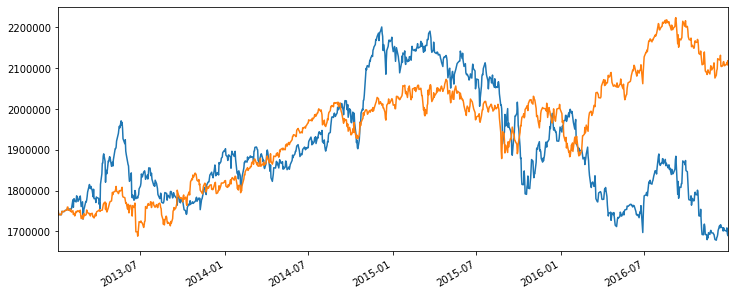

In [44]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))
results[0].profit

The weights vector of the portfolio in time.

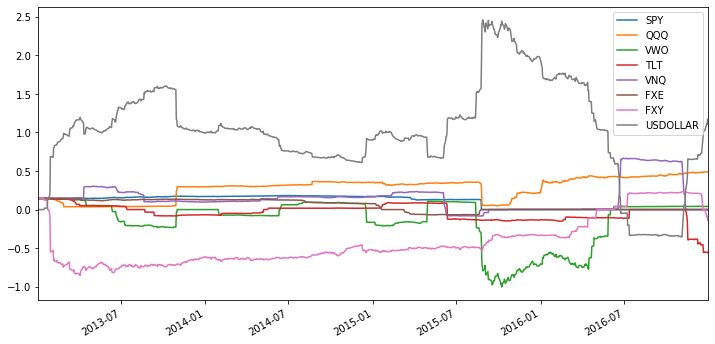

In [45]:
results[0].w.plot(figsize=(12,6))